# Calibration Tests

## Using data from: http://archive.ics.uci.edu/dataset/361/twin+gas+sensor+arrays

In [2]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATASET_PATH = 'data1/'

In [7]:
### Convert all the TXT files to CSV

def txt_to_csv(txt_filename, header):
    with open(txt_filename, 'r') as txt_file:
        content = txt_file.readlines()

    # Split each line into columns and remove leading/trailing whitespaces
    content = [line.strip().split() for line in content]

    # Write the data into a CSV file
    csv_filename = txt_filename.replace('.txt', '.csv')
    with open(csv_filename, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(header)
        writer.writerows(content)

header = ['timestamp', 'TGS2611-5.65','TGS2612-5.65','TGS2610-5.65','TGS2602-5.65','TGS2611-5.00','TGS2612-5.00','TGS2610-5.00', 'TGS2602-5.00']  # Custom header for the CSV file
for filename in os.listdir(DATASET_PATH):
    txt_to_csv(DATASET_PATH+filename, header)

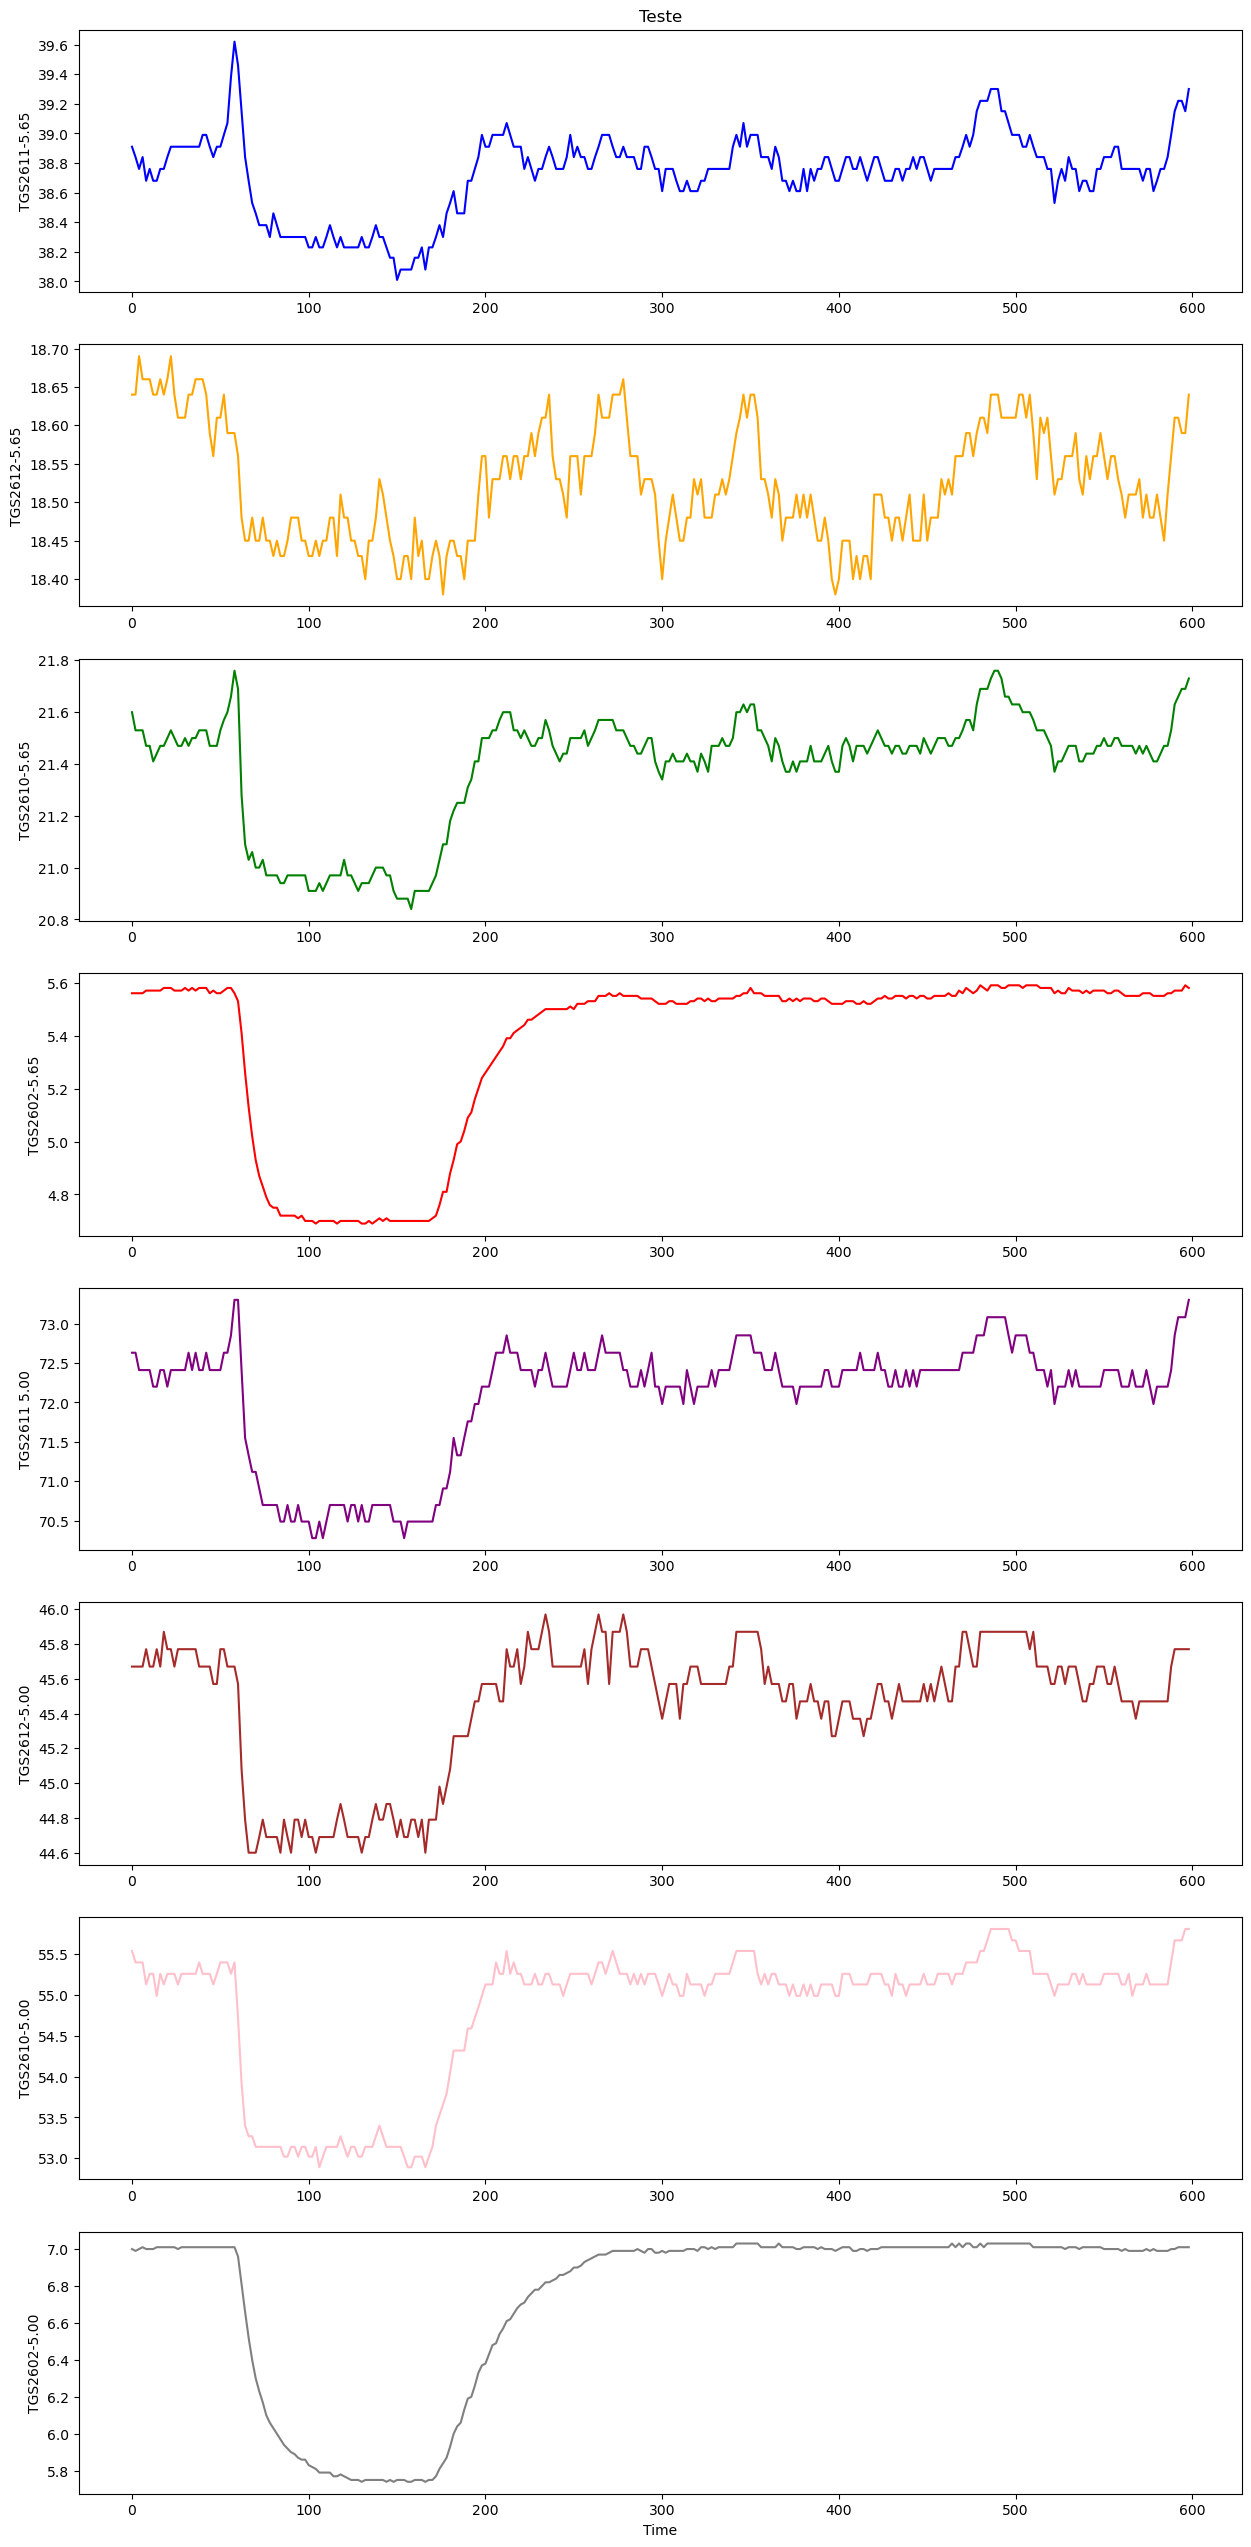

In [44]:
### Visualize the data first

def plot_data_from_csv(csv_file, column_list, graph_name):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Extract the header names as time vector and data series
    time_vector = 'timestamp'
    
    # Create the figure and axis objects
    fig, ax = plt.subplots(len(column_list)-1, figsize=(15,(len(column_list)-1)*4))
    color_names = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']
    
    ax[0].set_title(graph_name)
    for i in range(len(column_list)-1):
        ax[i].plot(df[time_vector], df[column_list[i+1]], color=color_names[i % len(color_names)])
        ax[i].set_ylabel(column_list[i+1])
        
    ax[i].set_xlabel('Time')
    # Show the plot
    plt.show()

header = ['timestamp','TGS2611-5.65','TGS2612-5.65','TGS2610-5.65','TGS2602-5.65','TGS2611-5.00','TGS2612-5.00','TGS2610-5.00','TGS2602-5.00']
for filename in os.listdir(DATASET_PATH):
    plot_data_from_csv(DATASET_PATH+'new_'+filename, header, 'Teste')
    break

In [120]:
### Downsample all the data


def downsample_csv(input_file, output_file, sample_period):
    with open(input_file, 'r') as csv_file:
        reader = csv.reader(csv_file)
        rows = list(reader)

    # Extract the header and data rows from the CSV
    header = rows[0]
    data = rows[1:]

    # Determine the column index of the timestamp column
    timestamp_column = 0

    # Find the nearest multiple of the sample period for downsampling
    downsampled_data = [data[0]]
    previous_timestamp = float(data[0][timestamp_column])
    for row in data[1:]:
        timestamp = float(row[timestamp_column])
        if timestamp >= previous_timestamp + sample_period:
            Counter([type(value) for value in row])
            downsampled_data.append(row)
            previous_timestamp = timestamp

    # Write the downsampled data to a new CSV file
    with open(output_file, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(header)
        writer.writerows(downsampled_data)

def truncate_decimal_values(csv_file, column_name, decimal_places):
    df = pd.read_csv(csv_file)
    df[column_name] = df[column_name].apply(lambda x: round(x, decimal_places))
    df.to_csv(csv_file,index=False)

def delete_empty_lines(file_path):
    # Read the file
    with open(file_path, 'r') as file:
        content = file.read()

    # Remove the last newline character if present
    if content.endswith('\n'):
        content = content[:-1]

    # Overwrite the file with the modified content
    with open(file_path, 'w') as file:
        file.write(content)


for filename in os.listdir(DATASET_PATH):
    downsample_csv(DATASET_PATH+filename, DATASET_PATH+'new_'+filename, 2)
    truncate_decimal_values(DATASET_PATH+'new_'+filename, 'timestamp', 0)
    delete_empty_lines(DATASET_PATH+'new_'+filename)

In [5]:
def calculate_transformation_matrix(S1, S2):
    S2_pseudo_inverse = np.linalg.pinv(S2)
    F = np.matmul(S2_pseudo_inverse, S1)
    return F

def map_to_master_space(new_sample, transformation_matrix):
    mapped_sample = np.matmul(new_sample, transformation_matrix)
    return mapped_sample


In [5]:
def concatenate_columns(folder_path, output_file):
    # Get a list of all CSV files in the folder
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

    with open(output_file, 'w') as csv_file:
        for file in csv_files:
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)

            # Exclude the 'timestamp' column
            columns_to_concatenate = [col for col in df.columns if col != 'timestamp']

            # Concatenate the columns without the header names
            concatenated_data = pd.concat([df[col] for col in columns_to_concatenate], ignore_index=True)

            # Save the concatenated data as a new row in the output file
            csv_file.write(','.join(str(value) for value in concatenated_data.tolist()) + '\n')


concatenate_columns('data1/calibration_samples/master', 'data1/calibration_samples/master_samples.csv')
concatenate_columns('data1/calibration_samples/slave', 'data1/calibration_samples/slave_samples.csv')
concatenate_columns('data1/calibration_samples/new', 'data1/calibration_samples/new_samples.csv')

In [55]:
master_df = pd.read_csv('data1/calibration_samples/master_samples.csv', header=None)
slave_df = pd.read_csv('data1/calibration_samples/slave_samples.csv', header=None)
new_df = pd.read_csv('data1/calibration_samples/new_samples.csv', header=None)

F = calculate_transformation_matrix(master_df.values, slave_df.values)

mapped_values = map_to_master_space(new_df.values, F)

header = ['timestamp', 'TGS2611-5.65','TGS2612-5.65','TGS2610-5.65','TGS2602-5.65','TGS2611 5.00','TGS2612-5.00','TGS2610-5.00', 'TGS2602-5.00']  # Custom header for the CSV file

mapped_df = pd.DataFrame()
mapped_df[header[0]] = range(0,600,2)
for i in range(8):
    mapped_df[header[i+1]] = pd.DataFrame(mapped_values.T[300*i:300+300*i])

mapped_df.to_csv('data1/calibration_samples/mapped_samples.csv',index=False)

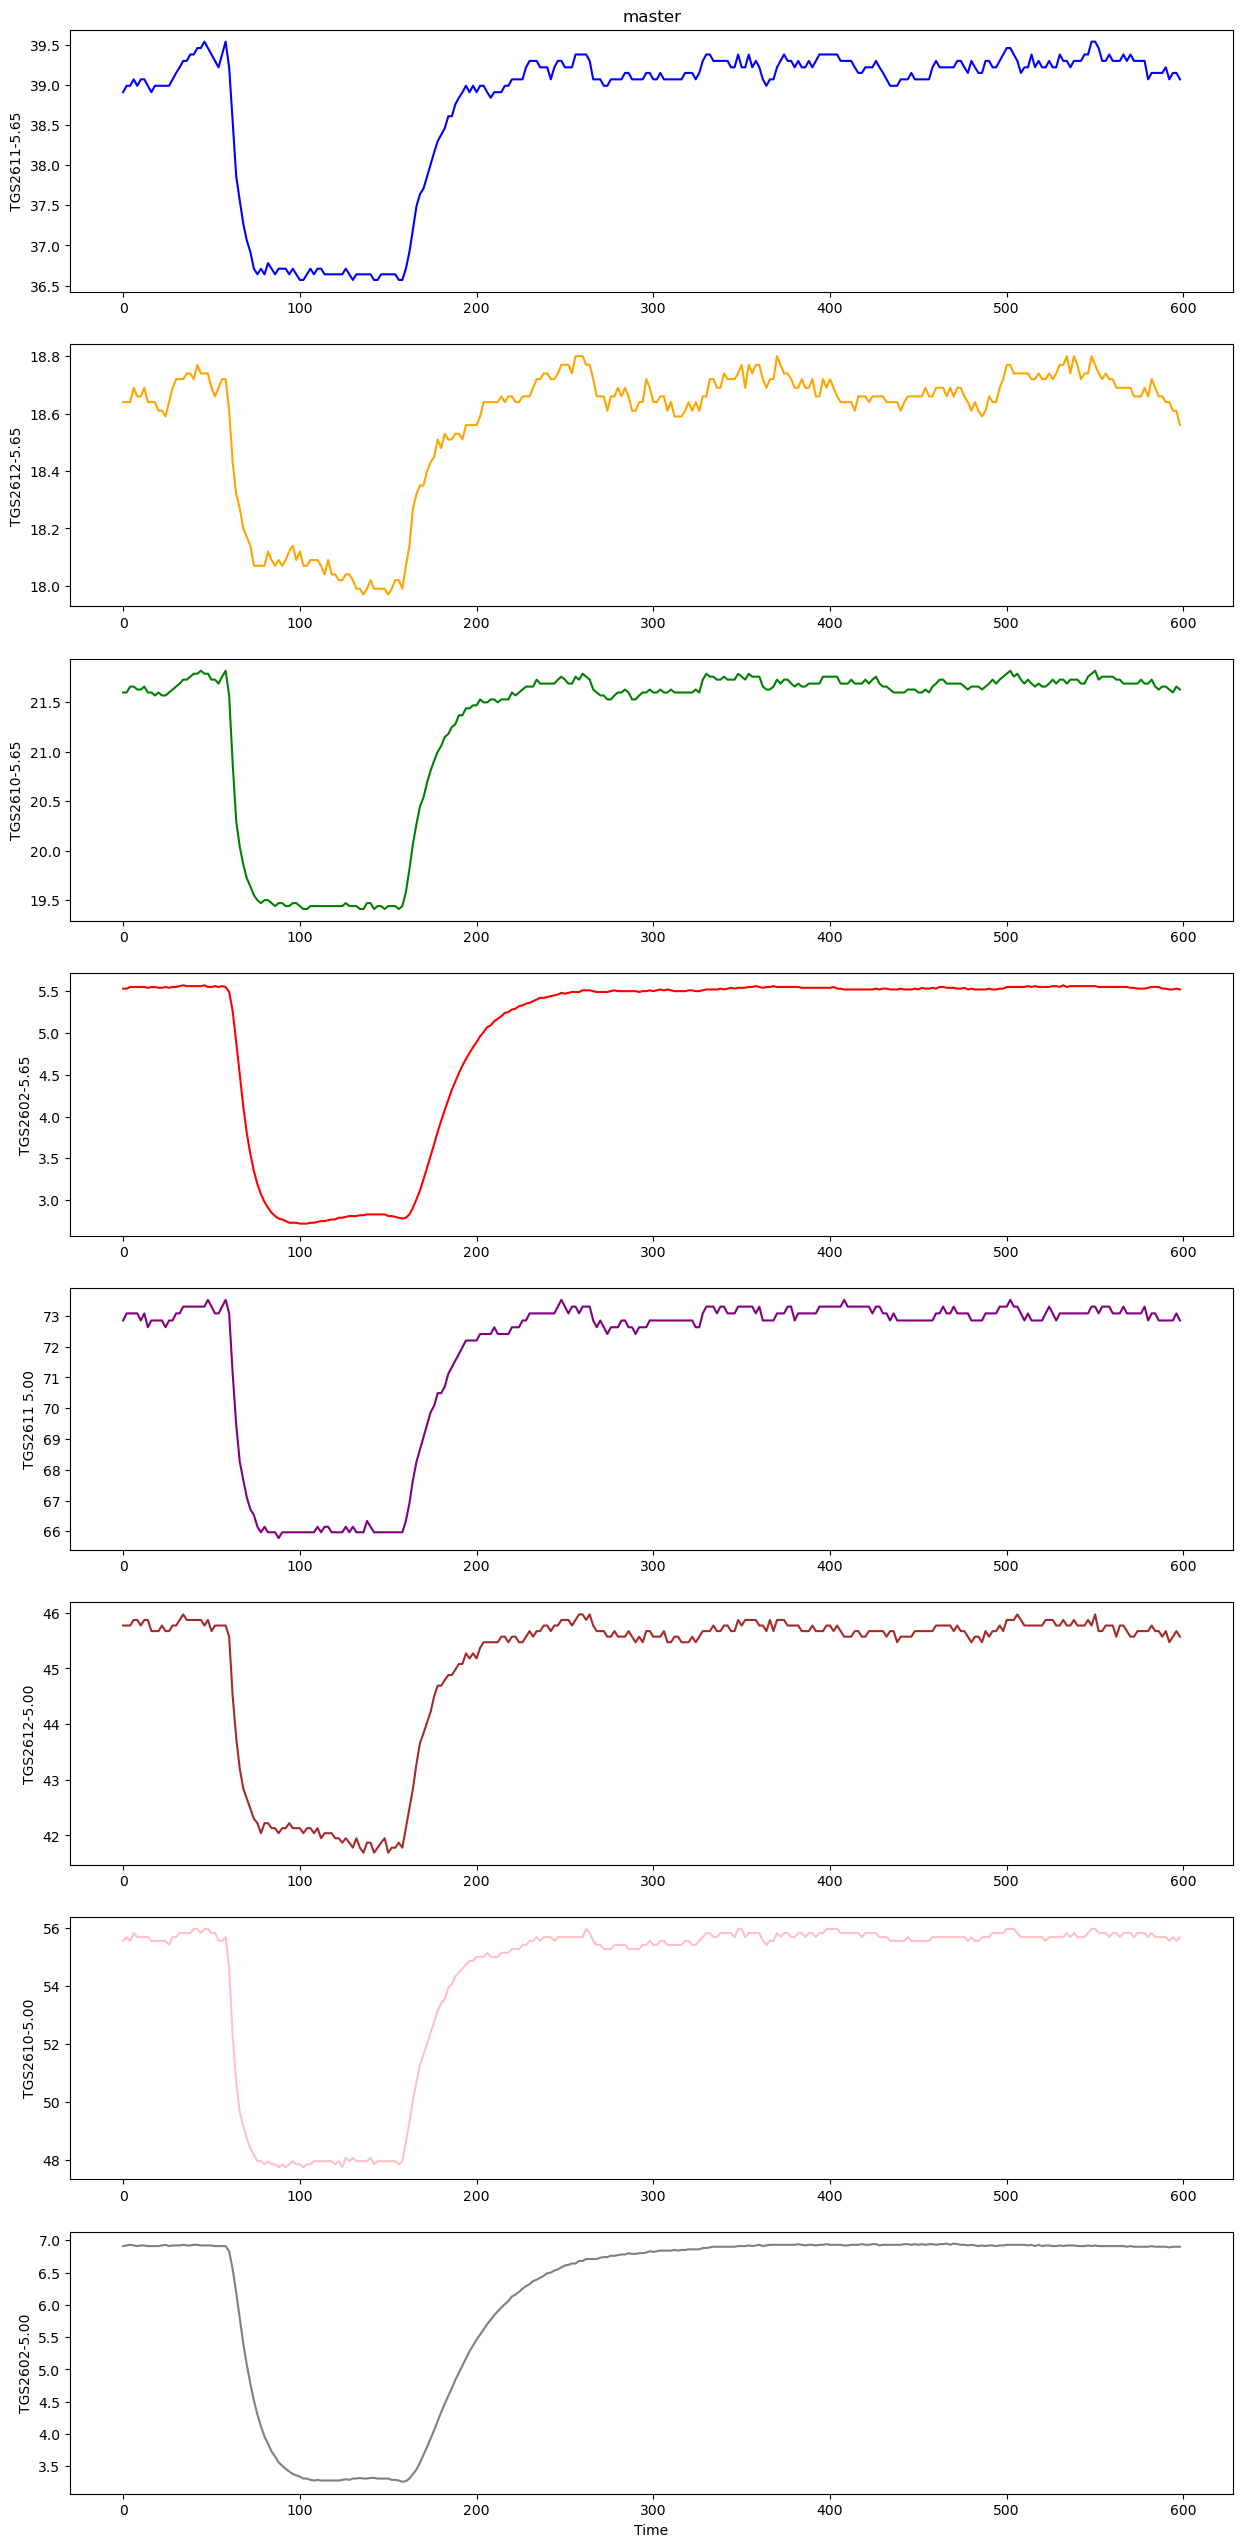

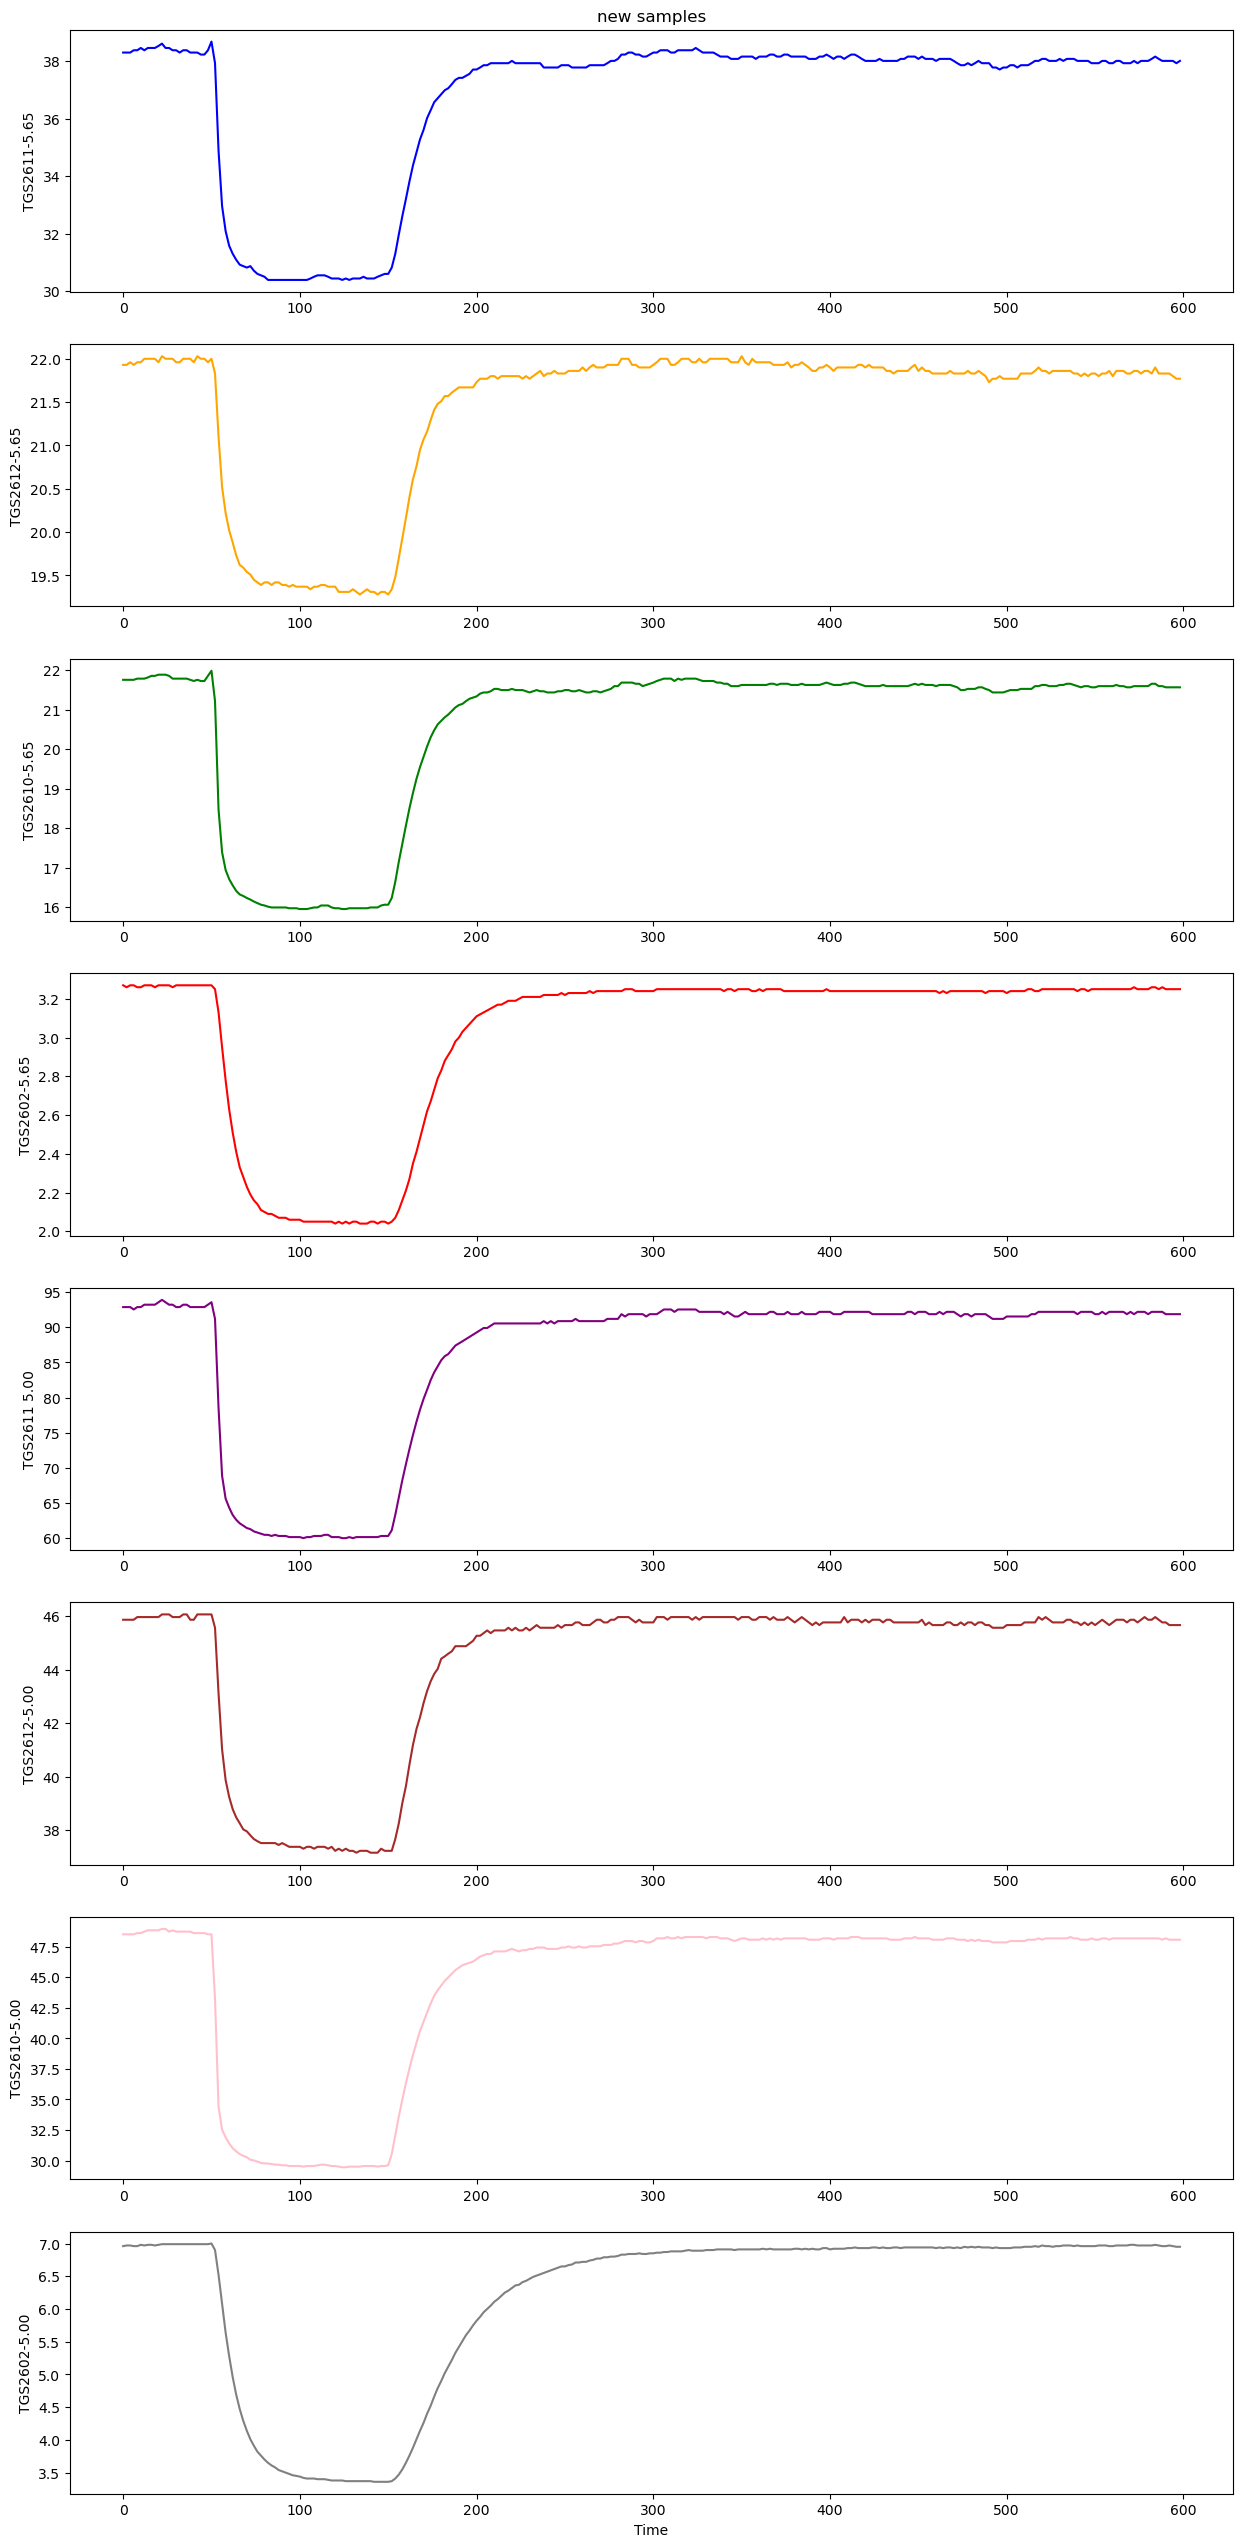

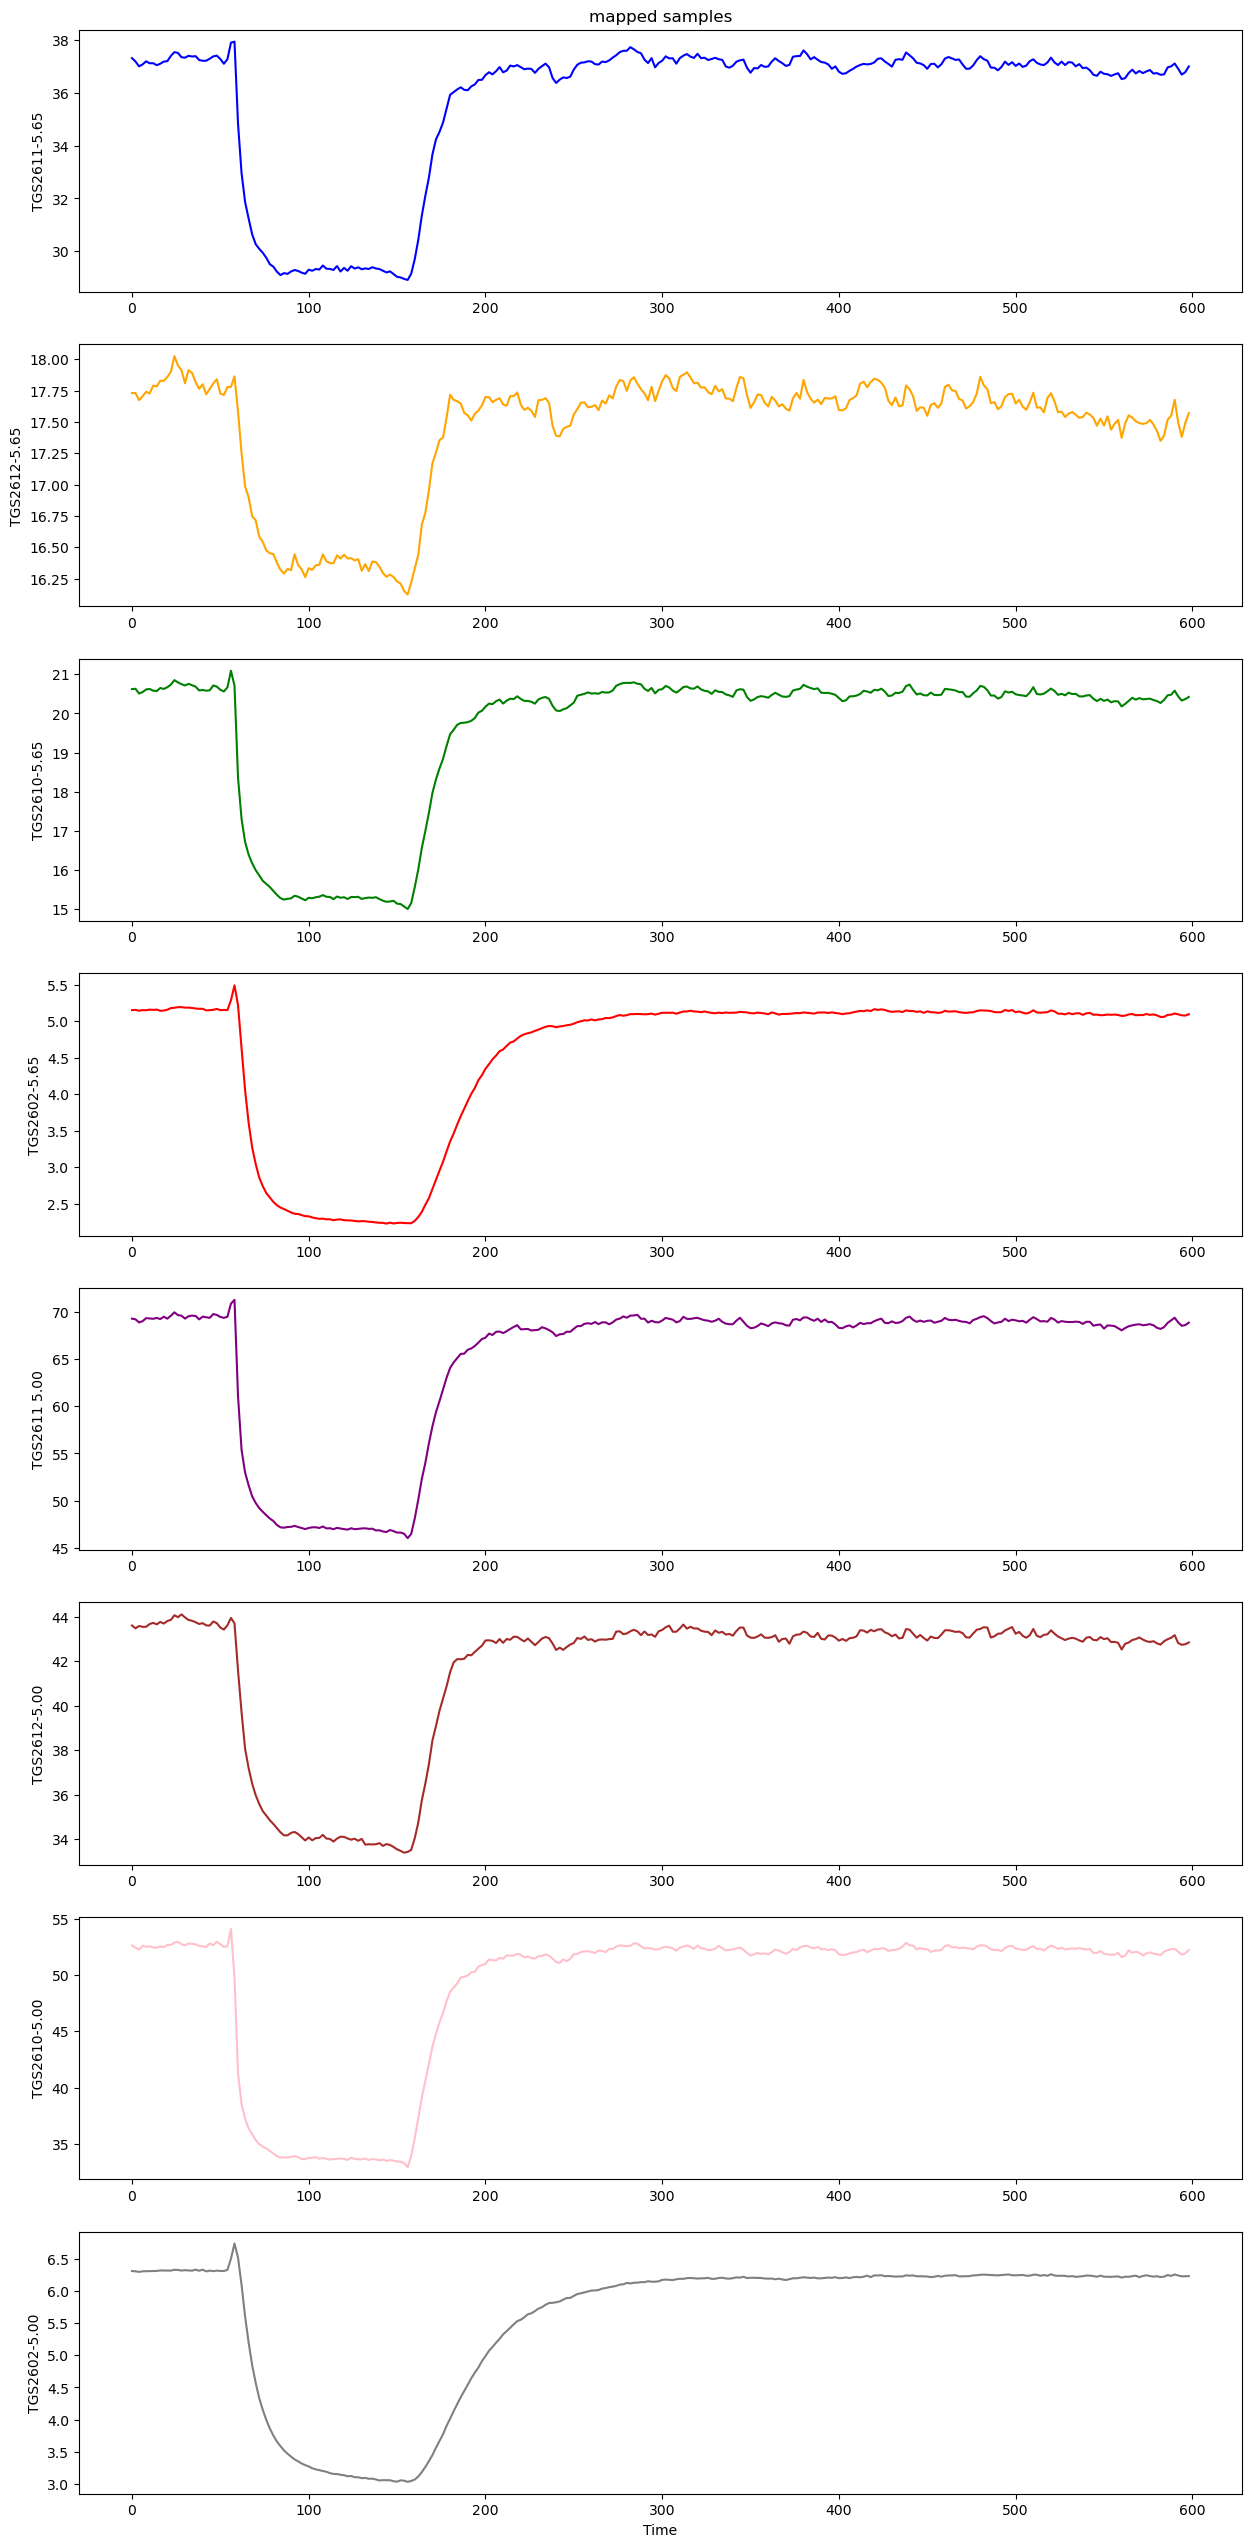

In [58]:
plot_data_from_csv('data1/calibration_samples/master/new_B1_GCO_F080_R1.csv', header, 'master')
plot_data_from_csv('data1/calibration_samples/new/new_B2_GEy_F040_R2.csv', header, 'new samples')
plot_data_from_csv('data1/calibration_samples/mapped_samples.csv', header, 'mapped samples')

